In [1]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio
from tensorflow.keras.initializers import he_normal
import datetime
import pandas as pd
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from PIL import Image
import glob
from sklearn.cluster import KMeans
# import tensorflow_addons as tfa
import pickle
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import umap

In [3]:
batch_size = 64
num_channels = 3
image_size = 64
latent_dim = 128
num_features = 1
root = './'
images_root = root + 'images/'

In [4]:
df = pd.read_csv(root + 'features_JM28_3Lines_DNA_H2AX_ki67_20240401.csv')
data = df.iloc[:,11:].values
data = StandardScaler().fit_transform(data)

In [5]:
df.shape

(21000, 28)

In [6]:
df.head()

,UMAP1,UMAP2,Metadata_Lines,Metadata_Well,Metadata_Fr,ImageNumber,ObjectNumber,Metadata_Seq,FileName_DNA,Unnamed: 9,...,Intensity_StdIntensityEdge_DNA,Intensity_MaxIntensity_H2AX,AreaShape_Solidity,Intensity_StdIntensityEdge_Ki67,Intensity_MADIntensity_DNA,AreaShape_HuMoment_2,Intensity_MassDisplacement_H2AX,AreaShape_InertiaTensor_0_0,Intensity_MassDisplacement_DNA,Intensity_MassDisplacement_Ki67
0,-2.504595,-0.615515,555926,C03,0,13,5,0,Plate555926_WellC03_yH2AX_KI67_Seq0000_C03_000...,NaN,...,0.037975,0.039316,0.738162,0.087413,0.026984,0.034752,0.232533,230.023496,1.249155,2.530670
1,-1.282245,5.933108,555926,C03,0,13,7,0,Plate555926_WellC03_yH2AX_KI67_Seq0000_C03_000...,NaN,...,0.019298,0.041758,0.974891,0.004925,0.026252,0.000203,0.315801,86.777946,1.184209,0.385245
2,-1.671308,5.619950,555926,C03,0,13,13,0,Plate555926_WellC03_yH2AX_KI67_Seq0000_C03_000...,NaN,...,0.038834,0.038828,0.915789,0.010994,0.028083,0.000947,0.032313,85.468839,1.385450,0.517205
3,-1.422702,4.790870,555926,C03,0,13,15,0,Plate555926_WellC03_yH2AX_KI67_Seq0000_C03_000...,NaN,...,0.021407,0.038339,0.972588,0.034148,0.030769,0.000035,0.157187,66.895699,0.153982,0.647428
4,-2.226727,5.959783,555926,C03,0,13,16,0,Plate555926_WellC03_yH2AX_KI67_Seq0000_C03_000...,NaN,...,0.057893,0.045177,0.969016,0.013539,0.036630,0.000048,0.177965,112.718208,1.793111,0.940920


/share/apps/genomap/1.3.6/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


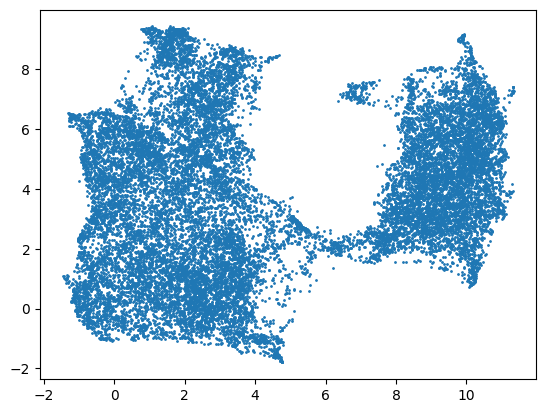

In [7]:
_umap = umap.UMAP(random_state=123)
embbedings_data = _umap.fit_transform(data)
plt.scatter(embbedings_data[:,0], embbedings_data[:,1],s=1)
plt.show()

(12987, 17)


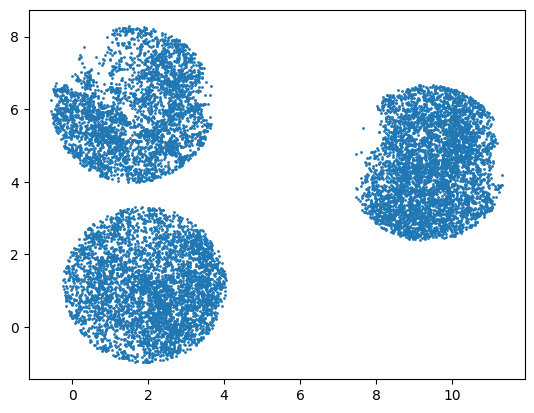

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(embbedings_data)
labels = kmeans.predict(embbedings_data)
centroids = kmeans.cluster_centers_
distances = [np.linalg.norm(x-centroids[labels[i]]) for i,x in enumerate(embbedings_data)]

threshold = 2.5*np.std(distances)

data = data[np.where(distances < threshold)]
clusters = kmeans.labels_[np.where(distances < threshold)]
embbedings_data = embbedings_data[np.where(distances < threshold)]
print(data.shape)

plt.scatter(embbedings_data[:,0], embbedings_data[:,1],s=1)
plt.show()

In [9]:
pickle.dump(kmeans, open(root+"kmeans.pickle", "wb"))

pickle.dump(_umap, open(root+"umap.pickle", "wb"))

In [10]:
df = df[distances < threshold]

clusters = (clusters / 3) - 0.5
df['clusters'] = clusters
print(np.unique(clusters))

[-0.5        -0.16666667  0.16666667]


In [11]:
df.shape

(12987, 29)

In [12]:
img_files = os.listdir(images_root)
print(len(img_files))

21000


In [13]:
df['FileName_DNA'] =  df['FileName_DNA'].str.replace('.tif','') + "_FilterNuclei_" + df['ObjectNumber'].astype(str) +'.png'

In [14]:
df = df[df['FileName_DNA'].isin(img_files)]
df['FileName_DNA'] = images_root + df['FileName_DNA']
print(len(df))

12987


In [15]:
def map_fn(path, c):
    image = tf.image.decode_png(tf.io.read_file(path),channels=num_channels)
    #image = tfa.image.equalize(image)
    image = tf.image.resize_with_crop_or_pad(image, target_height=image_size,target_width=image_size)
    image = (tf.cast(image, tf.float32)-127.5) / 127.5

    image = tf.clip_by_value(image + 0.1, -1.0, 1.0)

    return image, c

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((df['FileName_DNA'].values, df['clusters'].values.astype('float32').reshape(-1,1)))
dataset = dataset.map(map_fn)
dataset = (dataset
    .shuffle(1024)
    .cache()
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

-0.9 -0.045098044 -0.861065 0.088215


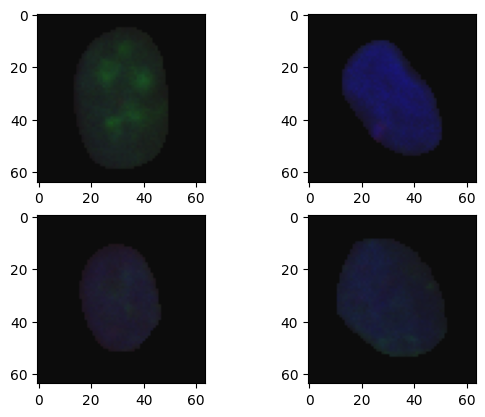

In [17]:
for x, y in dataset.take(1):
  print(np.min(x),np.max(x),np.mean(x),np.std(x))
  x = np.clip(x, -1 ,1)
  x = x * 0.5 + 0.5
  x *= 255.0
  x = x.astype(np.uint8)
  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x[i])
  plt.show()

In [18]:
generator_in_channels = latent_dim + num_features
discriminator_in_channels = num_channels + num_features
print(generator_in_channels, discriminator_in_channels)

129 4


In [19]:
def get_discriminator():
  input_layer = layers.Input(shape=(image_size,image_size,num_channels+1))
  x = layers.Conv2D(32 , (7,7) , padding='same',strides=2,use_bias=True)(input_layer)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(64 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(128 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2D(256 , (7,7) , padding='same',strides=2,use_bias=True)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(256 , activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)
  model = tf.keras.models.Model(input_layer,x, name='discriminator')
  print(model.summary())
  return model

In [20]:
def get_geneator():
  input_layer = layers.Input(shape=(latent_dim+num_features))
  x = layers.Dense(8 * 8 * (latent_dim+num_features))(input_layer)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((8, 8, latent_dim+num_features))(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Conv2DTranspose(num_channels, (5, 5), strides=(1, 1), padding="same",use_bias=True)(x)
  # x = layers.BatchNormalization()(x)
  x = layers.Activation("tanh")(x)
  model = tf.keras.models.Model(input_layer,x, name='generator')
  print(model.summary())
  return model


In [21]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim,batch_size):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.batch_size = batch_size
        self.d_steps = 3
        self.gp_weight = 10

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
        # return [self.gen_loss_tracker, tf.keras.metrics.Accuracy()]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn,g_loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        # Unpack the data.
        real_images, features = data

        for i in range(self.d_steps):
            image_of_features = tf.repeat(
                      features, repeats=[image_size * image_size] ,axis=1
                  )
            image_of_features = tf.reshape(
                image_of_features, (-1, image_size, image_size, 1)
            )
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_features = tf.concat(
                [random_latent_vectors, features], axis=1
            )

            with tf.GradientTape() as tape:
                self.discriminator.trainable = True
                # Generate fake images from the latent vector
                fake_images = self.generator(random_vector_features,training=True)
                fake_image_and_features = tf.concat([fake_images, image_of_features], -1)
                real_image_and_features = tf.concat([real_images, image_of_features], -1)

                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_image_and_features, training=True)

                # Get the logits for the real images
                real_logits = self.discriminator(real_image_and_features, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_image_and_features, fake_image_and_features)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )


        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_features = tf.concat(
                [random_latent_vectors, features], axis=1
            )

        with tf.GradientTape() as g_tape:
            self.discriminator.trainable = False

            g_tape.watch(self.generator.trainable_variables)

            # Generate fake images using the generator
            generated_images = self.generator(random_vector_features, training=True)
            # Get the discriminator logits for fake images
            fake_image_and_features = tf.concat([generated_images, image_of_features], -1)
            gen_img_logits = self.discriminator(fake_image_and_features, training=True)

            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = g_tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )



        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {"d_loss": d_loss, "g_loss": g_loss}


In [22]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [23]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=128, feature=[]):
        self.latent_dim = latent_dim
        self.feature = feature

    def on_epoch_end(self, epoch, logs=None):
        # Sample noise for the interpolation.
        _noise = tf.random.normal(shape=(len(self.feature), latent_dim))
        labels = np.array(self.feature).reshape((len(self.feature),num_features))

        # Combine the noise and the labels and run inference with the generator.
        _noise_and_labels = tf.concat([_noise, labels], 1)
        fake_images = self.model.generator.predict(_noise_and_labels)
        fake_images = np.clip(fake_images, -1 ,1)
        # print(np.mean(fake_images))
        # print(np.std(fake_images))
        fake_images = fake_images * 0.5 + 0.5
        fake_images *= 255.0
        converted_images = fake_images.astype(np.uint8)
        # converted_images = tf.image.resize(converted_images, (256, 256)).numpy().astype(np.uint8)


        for i in range(len(self.feature)):
          # plt.subplot(2,2,i+1)
          # plt.imshow(converted_images[i], cmap='gray')
          plt.imsave(root+'result/epoch {}_{}.png'.format(epoch,i),converted_images[i])
          # plt.imsave(root+'result/epoch {}_{}.png'.format(epoch,i),converted_images[i,:,:,0], cmap='gray')

        plt.show()

        if epoch % 50 == 0 :
           self.model.generator.save(root + 'GE W-cGAN Generator.h5')
           self.model.discriminator.save(root + 'GE W-cGAN Discriminator.h5')


In [24]:
callback = GANMonitor(latent_dim=latent_dim,feature = [-0.5  ,      -0.16666667 , 0.16666667])

In [ ]:
cond_gan = ConditionalGAN(
    discriminator=get_discriminator(),
    generator=get_geneator(),
    latent_dim=latent_dim ,
    batch_size=batch_size
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.9),
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

hist=cond_gan.fit(dataset, epochs=3000 , callbacks=[callback])

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        6304      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        100416    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         401536    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)       

I0000 00:00:1715527460.811135   99704 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 0s 195ms/step d_loss: -139.0828 - g_loss: -61.16


/share/apps/eb/TensorFlow/2.15-torch2.2-Py3.10.8/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 34s 122ms/step - d_loss: -138.6743 - g_loss: -60.9866
Epoch 2/3000
203/203 [==============================] - 22s 107ms/step - d_loss: -39.7159 - g_loss: 99.0352
Epoch 3/3000
203/203 [==============================] - 22s 107ms/step - d_loss: -33.8019 - g_loss: 185.3900
Epoch 4/3000
203/203 [==============================] - 22s 108ms/step - d_loss: -34.6838 - g_loss: 188.5661
Epoch 5/3000
203/203 [==============================] - 22s 108ms/step - d_loss: -26.7312 - g_loss: 49.4927
Epoch 6/3000
203/203 [==============================] - 22s 110ms/step - d_loss: -14.7498 - g_loss: 5.6876
Epoch 7/3000
203/203 [==============================] - 22s 110ms/step - d_loss: -9.7673 - g_loss: 20.8505
Epoch 8/3000
203/203 [==============================] - 23s 111ms/step - d_loss: -8.2027 - g_loss: 20.0741
Epoch 9/3000
203/203 [==============================] - 22s 110ms/step - d_loss: -6.9419 - g_loss: 15.2661
Epoch 10/3000
203/203 [==================